<a href="https://colab.research.google.com/github/BirenderPanwar/EVA4_Phase1/blob/master/session12/assignment_A/EVA4S12A_main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment A: TINY IMAGENET DATASET
1. Download TINY IMAGENET ("http://cs231n.stanford.edu/tiny-imagenet-200.zip") dataset. 
2. Train ResNet18 on this dataset (70/30 split) for 50 Epochs. Target 50%+ Validation Accuracy. 

In [0]:
# mount gdrive
mount_drive = True
if mount_drive:
    from google.colab import drive
    drive.mount('/content/gdrive') 

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


# Check for current directory and necessary files availability

In [0]:
# check current directory
!pwd

/content


In [0]:
# change to working directory
cd '/content/gdrive/My Drive/TSAI/EVA_Phase1/session12/'

/content/gdrive/My Drive/TSAI/EVA_Phase1/session12


In [0]:
# verify if all necessary files are avaiabale in current directory for loading
!ls

print("\nfiles under /models: ")
!ls ./models/

print("\nfiles under /utils: ")
!ls ./utils/

print("\nfiles under /gradcam: ")
!ls ./gradcam/

data			      gradcam  saved_models	      utils
EVA4S12A_main_attempt1.ipynb  images   tiny-imagenet-200
EVA4S12A_main.ipynb	      models   tiny-imagenet-200_eva

files under /models: 
cifar10_net_cnn.py  __pycache__  quiz_dnn.py  resnet_custom.py	resnet.py

files under /utils: 
albumentations_utils.py  lr_range_test.py  __pycache__
common_utils.py		 model_history.py  regularization.py
data_utils.py		 model_utils.py    TinyImagenetDataset.py
lr_finder.py		 plot_utils.py

files under /gradcam: 
gradcam_abs.py	gradcam.py  gradcam_utils.py  __pycache__


# Load standard and custom python packages

In [0]:
# Load standard packages

from __future__ import print_function
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import os

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [0]:
import pkgutil
import importlib

# install "apex" model for mixed precision training if required.. this is needed for LRFinder
if pkgutil.find_loader("apex") is None:
   print("apex module does not exist")
   !pip install -U git+https://www.github.com/NVIDIA/apex --no-cache-dir

from utils.lr_finder import LRFinder # cutom module for LR finder

In [0]:
import albumentations # to apply image augmentation using albumentations library.
print(albumentations.__version__) # check verison

# this is to install and use albumentations latest package v0.4.5
album_version_needed = "0.4.5"
if albumentations.__version__ != album_version_needed:
  !pip install -U git+https://github.com/albu/albumentations # --no-cache-dir

0.4.5


In [0]:
# load custom python packages
import utils.common_utils as cutils          # common utililies fxn
import utils.model_utils as mutils           # utilities for basic conv block, depthwise seperable blocks, train, test, build fucntions
import utils.model_history as model_history  # utilitie for storing and visualizing model results
from utils.plot_utils import PlotUtils       # utilities for ploting images, model history, misclassified images etc
import models.cifar10_net_cnn as cifar10_net_cnn  # CIFAR10 network design using custom CNN network
import models.resnet as resnet                    # resnet model
from models.resnet_custom import EVAS11_ResNet    # custom resnet model for EVA session-11
from utils.lr_range_test import LRRangeTest       # module for finding Max LR

import utils.albumentations_utils as album_utils # utilities fxn based on albumentations
import gradcam.gradcam_abs as gradcamAbs         # abstraction for GradCam module

from utils.TinyImagenetDataset import TinyImagenetDataset

In [0]:
# to autoreload all the custom files when modified
import autoreload
%load_ext autoreload
%autoreload

# Check GPU avaiability
use cuda and get device with GPU

In [0]:
# check GPU availability and use cuda to get GPU device
cuda, device = cutils.get_device()

CUDA Available? True
Device:  cuda:0


# Basis configurations

In [0]:
config_params = dict(
    seed=1,
    batch_size=256,
    num_workers=4,
    epochs=50
)

# For reproducibility
torch.manual_seed(config_params["seed"])

if cuda:
    torch.cuda.manual_seed(config_params["seed"])

#Download TINY IMAGENET dataset
- url: "http://cs231n.stanford.edu/tiny-imagenet-200.zip"

In [0]:
import zipfile
import os
import requests
from io import StringIO, BytesIO

def download_dataset(url, zipfile_name):
    if (os.path.isdir(zipfile_name)):
        print ('Images already downloaded...')
        return
    r = requests.get(url, stream=True)
    print ('Downloading ' + url )
    #zip_ref = zipfile.ZipFile(StringIO.StringIO(r.content))
    zip_ref = zipfile.ZipFile(BytesIO(r.content))
    zip_ref.extractall('./')
    zip_ref.close()
    print('Downloading and extraction completed')

TINY_IMAGENET_URL = "http://cs231n.stanford.edu/tiny-imagenet-200.zip"
ZIP_FILENAME = "tiny-imagenet-200"
download_dataset(TINY_IMAGENET_URL,ZIP_FILENAME)

In [0]:
#!rm -rf "./tiny-imagenet-200"

In [0]:
#!unzip -q "/content/gdrive/My Drive/TSAI/dataset_imagenet/tiny-imagenet-200.zip"

# Data Preperation and split(70:30)

In [0]:
ORIG_IMAGE_DIR = "./tiny-imagenet-200"
DEST_IMAGE_DIR = "./tiny-imagenet-200_eva"
TRAIN_IMAGE_DIR = os.path.join(DEST_IMAGE_DIR,"train")
VAL_IMAGE_DIR = os.path.join(DEST_IMAGE_DIR,"val")

In [0]:
tiny_imagenet = TinyImagenetDataset(ORIG_IMAGE_DIR)

In [0]:
'''
tiny-imagenet-200 folder have training images of 100K and val images of 10K and each images are labeled
in their annotation files

approach:
1. combine complete train and val dataset, hence total=110K images
2. split dataset into 70:30 (train,val) ratio. class balance is maintained in the inner logic.
3. final dataset is create with folder DEST_IMAGE_DIR
4. final data structure is: 
DEST_IMAGE_DIR/train/{class_num}/{all images}
DEST_IMAGE_DIR/val/{class_num}/{all images}

where class_num is 0~199 because we have 200 classes
'''
tiny_imagenet.create_imagefolder(DEST_IMAGE_DIR)

Creating/Copying training dataset for class(n02504458,199): 100%|██████████| 200/200 [15:56<00:00,  4.78s/it]
Creating/Copying validation dataset for class(n02504458,199): 100%|██████████| 200/200 [07:10<00:00,  2.15s/it]

Execution time: 23.12 minutes
Total dataset: 110000, Training size: 77000, Validation size: 33000


In [0]:
# few class descriptions
classes = tuple(tiny_imagenet.class_name_list)
classes[:5]

('Egyptian cat', 'reel', 'volleyball', 'rocking chair', 'lemon')

# Albumentations: Data Preprocessing and Loading of dataset
1. first calculate the mean and std for the entire dataset. this will be used for dataset normalization during data transform
2. define data transforms: image augmentation, toSensor, normalization etc
3. load the dataset using data loader

In [0]:
means, stds = [0.4802, 0.4481, 0.3975], [0.2302, 0.2265, 0.2262]
print("means: {}".format(means))
print("stds: {}".format(stds))

means: [0.4802, 0.4481, 0.3975]
stds: [0.2302, 0.2265, 0.2262]


In [0]:
# to apply specific augmentation, set apply=True
# augmentaion is ignore is either apply=False or speific a attribute is missing
albumentations_args = dict(
            GeneralParams=dict(input_size=64, means=means, stds=stds),  
            RandomCrop=dict(apply=True, padding=8, p=0.70), 
            Rotate=dict(apply=True, limit=(-30,30), p=0.70),    
            HorizontalFlip=dict(apply=True, p=0.5),
            #ElasticTransform=dict(apply=False, sigma=50, alpha=1, alpha_affine=10, p=0.10),
            CoarseDropout=dict(apply=True, max_holes=1, max_height=16, max_width=16, min_height=16, min_width=16, p=0.70),
            Normalize=dict(apply=True))

albumentations_args

{'CoarseDropout': {'apply': True,
  'max_height': 16,
  'max_holes': 1,
  'max_width': 16,
  'min_height': 16,
  'min_width': 16,
  'p': 0.7},
 'GeneralParams': {'input_size': 64,
  'means': [0.4802, 0.4481, 0.3975],
  'stds': [0.2302, 0.2265, 0.2262]},
 'HorizontalFlip': {'apply': True, 'p': 0.5},
 'Normalize': {'apply': True},
 'RandomCrop': {'apply': True, 'p': 0.7, 'padding': 8},
 'Rotate': {'apply': True, 'limit': (-30, 30), 'p': 0.7}}

In [0]:
# data transform
train_transforms, test_transforms = album_utils.get_data_transform(albumentations_args)

CoarseDropout/Cutout is enabled
HorizontalFlip is enabled
RandomCrop is enabled
Rotate is enabled


In [0]:
# load data
train_loader, test_loader = album_utils.get_dataloader_img_folder(
                                            TRAIN_IMAGE_DIR, VAL_IMAGE_DIR,
                                            train_transforms, test_transforms, 
                                            batch_size=config_params["batch_size"], num_workers=config_params["num_workers"])

CUDA Available? True


# Visualize few training dataset and augmented images

In [0]:
# create PlotUtils class instance
putils = PlotUtils(device, classes, means, stds)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

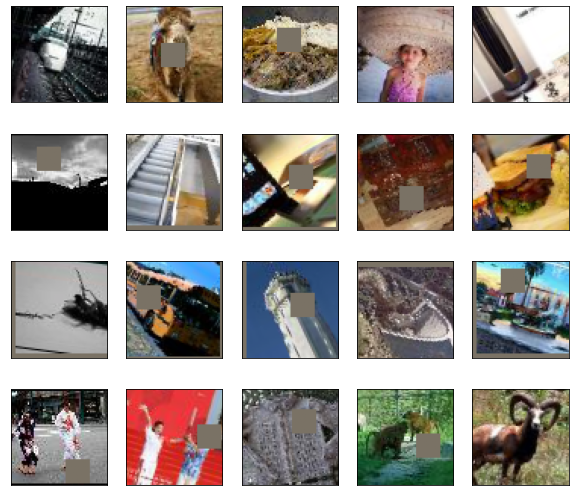

In [0]:
# visualize how image aumentation is applied on few training dataset images: 
putils.plot_dataset_images(train_loader, save_filename="albumentations_images")

# Create Resnet18 based Network

In [0]:
# Create Custom Resnet - EVS session 11
model = resnet.ResNet18_TinyImagenet()
mutils.model_summary(model, device, input_size=(3, 64, 64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 64, 64]           1,728
       BatchNorm2d-2           [-1, 64, 64, 64]             128
            Conv2d-3           [-1, 64, 64, 64]          36,864
       BatchNorm2d-4           [-1, 64, 64, 64]             128
            Conv2d-5           [-1, 64, 64, 64]          36,864
       BatchNorm2d-6           [-1, 64, 64, 64]             128
        BasicBlock-7           [-1, 64, 64, 64]               0
            Conv2d-8           [-1, 64, 64, 64]          36,864
       BatchNorm2d-9           [-1, 64, 64, 64]             128
           Conv2d-10           [-1, 64, 64, 64]          36,864
      BatchNorm2d-11           [-1, 64, 64, 64]             128
       BasicBlock-12           [-1, 64, 64, 64]               0
           Conv2d-13          [-1, 128, 32, 32]          73,728
      BatchNorm2d-14          [-1, 128,

In [0]:
# Create CIFAR10 network - resnet18
#model = resnet.ResNet18()
#mutils.model_summary(model, device, input_size=(3, 32, 32))

# Create CIFAR10 network using custome CNN network
#model = cifar10_net_cnn.Cifar10Net(drop_val=0.10)
#mutils.model_summary(model, device, input_size=(3, 32, 32))

# LRFinder
The model is trained for num_iter iterations while the learning rate is increased from its initial value specified by the optimizer algorithm to end_lr. The increase can be linear (step_mode="linear") or exponential (step_mode="exp"); linear provides good results for small ranges while exponential is recommended for larger ranges

In [0]:
model = resnet.ResNet18_TinyImagenet()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=1e-7, momentum=0.9, nesterov=True, weight_decay=1e-3)
lr_finder = LRFinder(model, optimizer, criterion, device=device)
lr_finder.range_test(train_loader, end_lr=100, num_iter=200, step_mode="exp")

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()


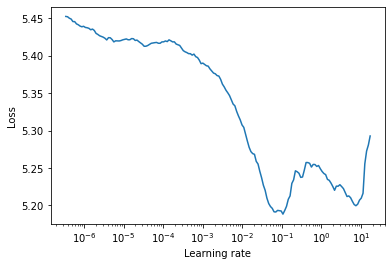

In [0]:
# Note that the loss in the loss vs. learning rate plot is the training loss.
lr_finder.plot()

In [0]:
max_lr = 0.1   # maximum LR as per LRFinder result
min_lr = 1e-4   # minimum LR as per LRFinder result
print("MAX LR: ", max_lr)
print("MIN LR: ", min_lr)

MAX LR:  0.1
MIN LR:  0.0001


# Build and train model

In [0]:
from torch.optim.lr_scheduler import CyclicLR, ReduceLROnPlateau

model_name = "CIFAR10 Resnet18"
model = resnet.ResNet18_TinyImagenet()
model =  model.to(device)
EPOCHS = config_params["epochs"]
L2_val = 0.001 

step_size = 8   # stepsize for Lr cycle policy

#criterion = F.nll_loss()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=min_lr, momentum=0.9, nesterov=True, weight_decay=L2_val)

# CyclicLR-Triangular policy
lr_scheduler = CyclicLR(optimizer, base_lr=min_lr, max_lr=max_lr, step_size_up=step_size, mode='triangular2', last_epoch=-1)
#lr_scheduler = MultiStepLR(optimizer, milestones=[8,16,24], gamma=0.3)
#lr_scheduler = StepLR(optimizer, step_size=8, gamma=0.1)

# reduce LR when modle get stuck in plateu region
reduceLr_scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=4, threshold=0.001)

m_history = mutils.build_model(model, 
                            device, 
                            trainloader=train_loader, 
                            testloader=test_loader, 
                            epochs=EPOCHS,
                            criterion=criterion, 
                            optimizer=optimizer,
                            lr_scheduler=lr_scheduler,
                            reduceLr_scheduler=reduceLr_scheduler,
                            L1_loss_enable=True)

  0%|          | 0/301 [00:00<?, ?it/s]

EPOCH-1: learning rate is: 0.0001


/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
Loss=5.534593 Batch_id=301 Accuracy=1.19 lr=0.0001: 100%|██████████| 301/301 [03:02<00:00,  1.65it/s]
  0%|          | 0/301 [00:00<?, ?it/s]


Test set: Average loss: 5.235950, Accuracy: 680/33000 (2.06%)

EPOCH-2: learning rate is: 0.0125875


Loss=4.712024 Batch_id=301 Accuracy=7.90 lr=0.0125875: 100%|██████████| 301/301 [03:07<00:00,  1.60it/s]
  0%|          | 0/301 [00:00<?, ?it/s]


Test set: Average loss: 4.146870, Accuracy: 3932/33000 (11.92%)

EPOCH-3: learning rate is: 0.025075


Loss=4.068012 Batch_id=301 Accuracy=15.85 lr=0.025075: 100%|██████████| 301/301 [03:09<00:00,  1.59it/s]
  0%|          | 0/301 [00:00<?, ?it/s]


Test set: Average loss: 3.878148, Accuracy: 4881/33000 (14.79%)

EPOCH-4: learning rate is: 0.037562500000000006


Loss=3.647790 Batch_id=301 Accuracy=22.19 lr=0.037562500000000006: 100%|██████████| 301/301 [03:08<00:00,  1.60it/s]
  0%|          | 0/301 [00:00<?, ?it/s]


Test set: Average loss: 3.535893, Accuracy: 6972/33000 (21.13%)

EPOCH-5: learning rate is: 0.050050000000000004


Loss=3.363706 Batch_id=301 Accuracy=26.80 lr=0.050050000000000004: 100%|██████████| 301/301 [03:05<00:00,  1.62it/s]
  0%|          | 0/301 [00:00<?, ?it/s]


Test set: Average loss: 3.588405, Accuracy: 6902/33000 (20.92%)

EPOCH-6: learning rate is: 0.0625375


Loss=3.149314 Batch_id=301 Accuracy=30.49 lr=0.0625375: 100%|██████████| 301/301 [03:13<00:00,  1.56it/s]
  0%|          | 0/301 [00:00<?, ?it/s]


Test set: Average loss: 3.219233, Accuracy: 8856/33000 (26.84%)

EPOCH-7: learning rate is: 0.07502500000000001


Loss=2.974885 Batch_id=301 Accuracy=33.59 lr=0.07502500000000001: 100%|██████████| 301/301 [03:07<00:00,  1.61it/s]
  0%|          | 0/301 [00:00<?, ?it/s]


Test set: Average loss: 2.897698, Accuracy: 10574/33000 (32.04%)

EPOCH-8: learning rate is: 0.08751250000000001


Loss=2.851354 Batch_id=301 Accuracy=35.78 lr=0.08751250000000001: 100%|██████████| 301/301 [03:07<00:00,  1.61it/s]
  0%|          | 0/301 [00:00<?, ?it/s]


Test set: Average loss: 3.078298, Accuracy: 9582/33000 (29.04%)

EPOCH-9: learning rate is: 0.1


  0%|          | 0/301 [00:00<?, ?it/s]


Test set: Average loss: 2.878999, Accuracy: 10743/33000 (32.55%)

EPOCH-10: learning rate is: 0.08751250000000001


Loss=2.592278 Batch_id=301 Accuracy=40.83 lr=0.08751250000000001: 100%|██████████| 301/301 [03:06<00:00,  1.61it/s]
  0%|          | 0/301 [00:00<?, ?it/s]


Test set: Average loss: 2.776138, Accuracy: 11462/33000 (34.73%)

EPOCH-11: learning rate is: 0.07502500000000001


Loss=2.478503 Batch_id=301 Accuracy=43.23 lr=0.07502500000000001: 100%|██████████| 301/301 [03:06<00:00,  1.62it/s]
  0%|          | 0/301 [00:00<?, ?it/s]


Test set: Average loss: 2.967402, Accuracy: 10556/33000 (31.99%)

EPOCH-12: learning rate is: 0.0625375


Loss=2.361452 Batch_id=301 Accuracy=45.68 lr=0.0625375: 100%|██████████| 301/301 [03:04<00:00,  1.63it/s]
  0%|          | 0/301 [00:00<?, ?it/s]


Test set: Average loss: 2.697322, Accuracy: 12251/33000 (37.12%)

EPOCH-13: learning rate is: 0.050050000000000004


Loss=2.241606 Batch_id=301 Accuracy=48.36 lr=0.050050000000000004: 100%|██████████| 301/301 [03:08<00:00,  1.59it/s]
  0%|          | 0/301 [00:00<?, ?it/s]


Test set: Average loss: 2.470315, Accuracy: 13453/33000 (40.77%)

EPOCH-14: learning rate is: 0.037562500000000006


Loss=2.116145 Batch_id=301 Accuracy=51.13 lr=0.037562500000000006: 100%|██████████| 301/301 [03:05<00:00,  1.62it/s]
  0%|          | 0/301 [00:00<?, ?it/s]


Test set: Average loss: 2.290971, Accuracy: 14661/33000 (44.43%)

EPOCH-15: learning rate is: 0.025075


Loss=1.956687 Batch_id=301 Accuracy=54.72 lr=0.025075: 100%|██████████| 301/301 [03:07<00:00,  1.61it/s]
  0%|          | 0/301 [00:00<?, ?it/s]


Test set: Average loss: 2.168453, Accuracy: 15508/33000 (46.99%)

EPOCH-16: learning rate is: 0.0125875


Loss=1.745325 Batch_id=301 Accuracy=59.80 lr=0.0125875: 100%|██████████| 301/301 [03:09<00:00,  1.59it/s]
  0%|          | 0/301 [00:00<?, ?it/s]


Test set: Average loss: 1.930436, Accuracy: 17279/33000 (52.36%)

EPOCH-17: learning rate is: 0.0001


Loss=1.586458 Batch_id=301 Accuracy=63.95 lr=0.0001: 100%|██████████| 301/301 [03:09<00:00,  1.59it/s]
  0%|          | 0/301 [00:00<?, ?it/s]


Test set: Average loss: 1.767889, Accuracy: 18426/33000 (55.84%)

EPOCH-18: learning rate is: 0.00634375


Loss=1.565711 Batch_id=301 Accuracy=64.08 lr=0.00634375: 100%|██████████| 301/301 [03:05<00:00,  1.62it/s]
  0%|          | 0/301 [00:00<?, ?it/s]


Test set: Average loss: 1.785946, Accuracy: 18320/33000 (55.52%)

EPOCH-19: learning rate is: 0.0125875


Loss=1.645913 Batch_id=301 Accuracy=61.88 lr=0.0125875: 100%|██████████| 301/301 [03:07<00:00,  1.60it/s]
  0%|          | 0/301 [00:00<?, ?it/s]


Test set: Average loss: 1.911446, Accuracy: 17445/33000 (52.86%)

EPOCH-20: learning rate is: 0.01883125


Loss=1.746531 Batch_id=301 Accuracy=59.10 lr=0.01883125: 100%|██████████| 301/301 [03:07<00:00,  1.60it/s]
  0%|          | 0/301 [00:00<?, ?it/s]


Test set: Average loss: 2.074642, Accuracy: 16234/33000 (49.19%)

EPOCH-21: learning rate is: 0.025075


Loss=1.831649 Batch_id=301 Accuracy=57.13 lr=0.025075: 100%|██████████| 301/301 [03:31<00:00,  1.43it/s]
  0%|          | 0/301 [00:00<?, ?it/s]


Test set: Average loss: 2.197405, Accuracy: 15572/33000 (47.19%)

EPOCH-22: learning rate is: 0.03131875


Loss=1.890317 Batch_id=301 Accuracy=55.95 lr=0.03131875: 100%|██████████| 301/301 [03:05<00:00,  1.62it/s]
  0%|          | 0/301 [00:00<?, ?it/s]


Test set: Average loss: 2.344214, Accuracy: 14685/33000 (44.50%)

EPOCH-23: learning rate is: 0.003756250000000001


Loss=1.481191 Batch_id=301 Accuracy=66.40 lr=0.003756250000000001: 100%|██████████| 301/301 [03:05<00:00,  1.63it/s]
  0%|          | 0/301 [00:00<?, ?it/s]


Test set: Average loss: 1.694759, Accuracy: 19064/33000 (57.77%)

EPOCH-24: learning rate is: 0.043806250000000005


Loss=1.986885 Batch_id=301 Accuracy=53.64 lr=0.043806250000000005: 100%|██████████| 301/301 [03:06<00:00,  1.61it/s]
  0%|          | 0/301 [00:00<?, ?it/s]


Test set: Average loss: 2.495350, Accuracy: 13613/33000 (41.25%)

EPOCH-25: learning rate is: 0.050050000000000004


Loss=2.005179 Batch_id=301 Accuracy=53.53 lr=0.050050000000000004: 100%|██████████| 301/301 [03:00<00:00,  1.66it/s]
  0%|          | 0/301 [00:00<?, ?it/s]


Test set: Average loss: 2.373214, Accuracy: 14151/33000 (42.88%)

EPOCH-26: learning rate is: 0.043806250000000005


Loss=1.902094 Batch_id=301 Accuracy=55.98 lr=0.043806250000000005: 100%|██████████| 301/301 [03:02<00:00,  1.65it/s]
  0%|          | 0/301 [00:00<?, ?it/s]


Test set: Average loss: 2.405061, Accuracy: 14309/33000 (43.36%)

EPOCH-27: learning rate is: 0.037562500000000006


Loss=1.807428 Batch_id=301 Accuracy=58.38 lr=0.037562500000000006: 100%|██████████| 301/301 [02:59<00:00,  1.67it/s]
  0%|          | 0/301 [00:00<?, ?it/s]


Test set: Average loss: 2.372372, Accuracy: 14600/33000 (44.24%)

EPOCH-28: learning rate is: 0.03131875


Loss=1.710798 Batch_id=301 Accuracy=60.54 lr=0.03131875: 100%|██████████| 301/301 [02:58<00:00,  1.68it/s]
  0%|          | 0/301 [00:00<?, ?it/s]


Test set: Average loss: 2.096588, Accuracy: 15992/33000 (48.46%)

EPOCH-29: learning rate is: 0.0025075


Loss=1.342773 Batch_id=301 Accuracy=70.33 lr=0.0025075: 100%|██████████| 301/301 [02:58<00:00,  1.68it/s]
  0%|          | 0/301 [00:00<?, ?it/s]


Test set: Average loss: 1.616117, Accuracy: 19739/33000 (59.82%)

EPOCH-30: learning rate is: 0.01883125


Loss=1.468777 Batch_id=301 Accuracy=66.75 lr=0.01883125: 100%|██████████| 301/301 [02:54<00:00,  1.72it/s]
  0%|          | 0/301 [00:00<?, ?it/s]


Test set: Average loss: 1.918673, Accuracy: 17517/33000 (53.08%)

EPOCH-31: learning rate is: 0.0125875


Loss=1.319489 Batch_id=301 Accuracy=70.26 lr=0.0125875: 100%|██████████| 301/301 [02:58<00:00,  1.69it/s]
  0%|          | 0/301 [00:00<?, ?it/s]


Test set: Average loss: 1.810212, Accuracy: 18413/33000 (55.80%)

EPOCH-32: learning rate is: 0.00634375


Loss=1.133057 Batch_id=301 Accuracy=75.09 lr=0.00634375: 100%|██████████| 301/301 [03:00<00:00,  1.67it/s]
  0%|          | 0/301 [00:00<?, ?it/s]


Test set: Average loss: 1.665506, Accuracy: 19393/33000 (58.77%)

EPOCH-33: learning rate is: 0.0001


Loss=0.993163 Batch_id=301 Accuracy=79.53 lr=0.0001: 100%|██████████| 301/301 [03:02<00:00,  1.65it/s]
  0%|          | 0/301 [00:00<?, ?it/s]


Test set: Average loss: 1.583603, Accuracy: 19967/33000 (60.51%)

EPOCH-34: learning rate is: 0.003221875


Loss=0.988613 Batch_id=301 Accuracy=79.69 lr=0.003221875: 100%|██████████| 301/301 [03:03<00:00,  1.64it/s]
  0%|          | 0/301 [00:00<?, ?it/s]


Test set: Average loss: 1.597784, Accuracy: 19902/33000 (60.31%)

EPOCH-35: learning rate is: 0.00634375


Loss=1.027735 Batch_id=301 Accuracy=78.24 lr=0.00634375: 100%|██████████| 301/301 [03:05<00:00,  1.62it/s]
  0%|          | 0/301 [00:00<?, ?it/s]


Test set: Average loss: 1.709832, Accuracy: 19124/33000 (57.95%)

EPOCH-36: learning rate is: 0.009465625


Loss=1.107128 Batch_id=301 Accuracy=75.41 lr=0.009465625: 100%|██████████| 301/301 [03:06<00:00,  1.62it/s]
  0%|          | 0/301 [00:00<?, ?it/s]


Test set: Average loss: 1.780867, Accuracy: 18637/33000 (56.48%)

EPOCH-37: learning rate is: 0.0125875


Loss=1.203816 Batch_id=301 Accuracy=72.48 lr=0.0125875: 100%|██████████| 301/301 [03:06<00:00,  1.61it/s]
  0%|          | 0/301 [00:00<?, ?it/s]


Test set: Average loss: 1.905391, Accuracy: 17863/33000 (54.13%)

EPOCH-38: learning rate is: 0.015709375


Loss=1.316515 Batch_id=301 Accuracy=69.44 lr=0.015709375: 100%|██████████| 301/301 [03:05<00:00,  1.63it/s]
  0%|          | 0/301 [00:00<?, ?it/s]


Test set: Average loss: 2.024321, Accuracy: 17133/33000 (51.92%)

EPOCH-39: learning rate is: 0.0018831250000000003


Loss=0.962527 Batch_id=301 Accuracy=79.87 lr=0.0018831250000000003: 100%|██████████| 301/301 [03:01<00:00,  1.66it/s]
  0%|          | 0/301 [00:00<?, ?it/s]


Test set: Average loss: 1.591161, Accuracy: 20082/33000 (60.85%)

EPOCH-40: learning rate is: 0.021953125


Loss=1.475016 Batch_id=301 Accuracy=65.38 lr=0.021953125: 100%|██████████| 301/301 [03:03<00:00,  1.64it/s]
  0%|          | 0/301 [00:00<?, ?it/s]


Test set: Average loss: 2.080316, Accuracy: 16523/33000 (50.07%)

EPOCH-41: learning rate is: 0.025075


Loss=1.539576 Batch_id=301 Accuracy=63.99 lr=0.025075: 100%|██████████| 301/301 [03:03<00:00,  1.64it/s]
  0%|          | 0/301 [00:00<?, ?it/s]


Test set: Average loss: 2.271463, Accuracy: 15410/33000 (46.70%)

EPOCH-42: learning rate is: 0.021953125


Loss=1.430804 Batch_id=301 Accuracy=67.01 lr=0.021953125: 100%|██████████| 301/301 [03:04<00:00,  1.63it/s]
  0%|          | 0/301 [00:00<?, ?it/s]


Test set: Average loss: 2.081893, Accuracy: 16554/33000 (50.16%)

EPOCH-43: learning rate is: 0.01883125


Loss=1.317049 Batch_id=301 Accuracy=70.06 lr=0.01883125: 100%|██████████| 301/301 [03:03<00:00,  1.64it/s]
  0%|          | 0/301 [00:00<?, ?it/s]


Test set: Average loss: 2.015718, Accuracy: 17116/33000 (51.87%)

EPOCH-44: learning rate is: 0.0015709375000000003


Loss=0.967554 Batch_id=301 Accuracy=80.25 lr=0.0015709375000000003: 100%|██████████| 301/301 [03:07<00:00,  1.60it/s]
  0%|          | 0/301 [00:00<?, ?it/s]


Test set: Average loss: 1.575448, Accuracy: 20160/33000 (61.09%)

EPOCH-45: learning rate is: 0.0125875


Loss=1.078239 Batch_id=301 Accuracy=76.63 lr=0.0125875: 100%|██████████| 301/301 [03:03<00:00,  1.64it/s]
  0%|          | 0/301 [00:00<?, ?it/s]


Test set: Average loss: 1.834097, Accuracy: 18435/33000 (55.86%)

EPOCH-46: learning rate is: 0.009465625


Loss=0.959938 Batch_id=301 Accuracy=79.85 lr=0.009465625: 100%|██████████| 301/301 [03:05<00:00,  1.63it/s]
  0%|          | 0/301 [00:00<?, ?it/s]


Test set: Average loss: 1.774171, Accuracy: 18914/33000 (57.32%)

EPOCH-47: learning rate is: 0.00634375


Loss=0.817228 Batch_id=301 Accuracy=83.95 lr=0.00634375: 100%|██████████| 301/301 [03:12<00:00,  1.57it/s]
  0%|          | 0/301 [00:00<?, ?it/s]


Test set: Average loss: 1.715969, Accuracy: 19360/33000 (58.67%)

EPOCH-48: learning rate is: 0.003221875


Loss=0.675032 Batch_id=301 Accuracy=88.25 lr=0.003221875: 100%|██████████| 301/301 [03:04<00:00,  1.63it/s]
  0%|          | 0/301 [00:00<?, ?it/s]


Test set: Average loss: 1.626727, Accuracy: 20023/33000 (60.68%)

EPOCH-49: learning rate is: 0.0001


Loss=0.593082 Batch_id=301 Accuracy=90.87 lr=0.0001: 100%|██████████| 301/301 [03:05<00:00,  1.62it/s]
  0%|          | 0/301 [00:00<?, ?it/s]


Test set: Average loss: 1.586716, Accuracy: 20280/33000 (61.45%)

EPOCH-50: learning rate is: 0.00016609375


Loss=0.576527 Batch_id=301 Accuracy=91.19 lr=0.00016609375: 100%|██████████| 301/301 [03:07<00:00,  1.60it/s]



Test set: Average loss: 1.579293, Accuracy: 20300/33000 (61.52%)



In [0]:
# Save the model for future use
filepath = "./saved_models/s11_resnet"
torch.save(model, filepath)

# Analyse the train and test best result and calculate test accuracy for each classes

In [0]:
# model result summary
m_history.result_summary()

Training best result: Accuracy: 91.19 at Epoch 50
Testing  best result: Accuracy: 61.52 at Epoch 50
Acuracy Gap: 29.67


# Visualize model history and network convergence

Visulaizing train and test result history

/content/gdrive/My Drive/TSAI/EVA_Phase1/session12/utils/model_history.py:110: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  axs[0].set_xticks(np.arange(1,x_size+1),x_size/10)
/content/gdrive/My Drive/TSAI/EVA_Phase1/session12/utils/model_history.py:121: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  axs[1].set_xticks(np.arange(1,x_size+1),x_size/10)


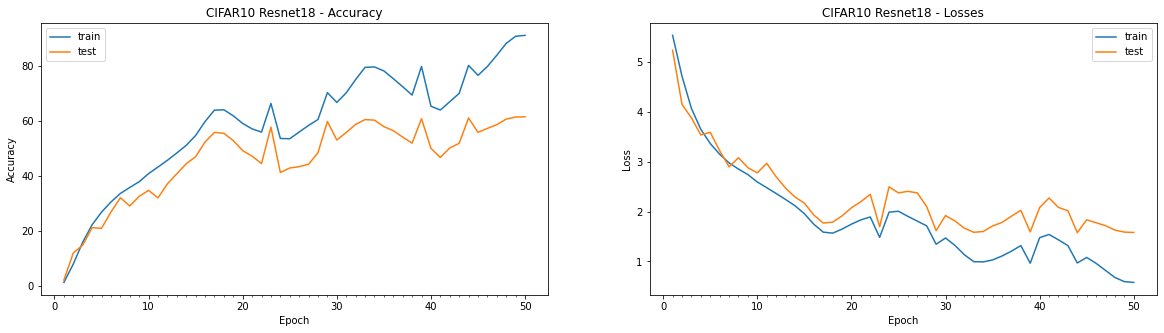

In [0]:
# Accurracy and loss history plot
m_history.plot_history(title=model_name, save_filename="model_history")

Learning rate plot

/content/gdrive/My Drive/TSAI/EVA_Phase1/session12/utils/model_history.py:68: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  axs.set_xticks(np.arange(1,x_size+1),x_size/10)


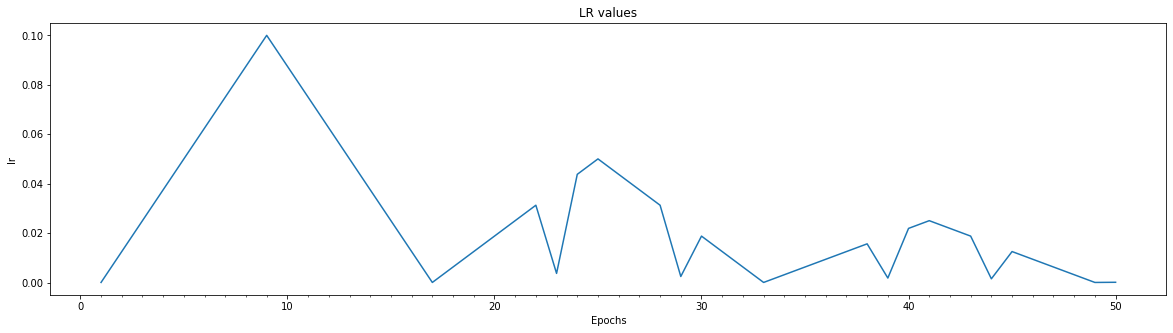

In [0]:
# Note: seriesname="val_acc", "val_loss", "train_acc", "train_loss", "lr"
m_history.plot_data_against_epoch("LR values", seriesname="lr", save_filename="lr_trend")